(sec:dtw)=
# Dynamic Time Warping

This section covers works related to Dynamic Time Warping for time series.

Dynamic Time Warping (DTW) {cite}`sakoe1978dynamic` is a similarity measure
between time series.
Consider two time series $\mathbf{x}$ and
$\mathbf{x}^\prime$ of respective lengths $n$ and
$m$.
Here, all elements $x_i$ and $x^\prime_j$ are assumed to lie in the same
$p$-dimensional space and the exact timestamps at which observations occur are
disregarded: only their ordering matters.

````{admonition} tslearn tip
:class: tip, dropdown

In ``tslearn``, such time series would be represented as arrays of
respective
shapes `(n, p)` and `(m, p)` and DTW can be computed using the following code:

```python
from tslearn.metrics import dtw, dtw_path

dtw_score = dtw(x, x_prime)
# Or, if the path is also
# an important information:
path, score = dtw_path(x, x_prime)
```

````

## Optimization Problem

In the following, a path $\pi$ of length $K$ is a
sequence of $K$ index pairs
$\left((i_0, j_0), \dots , (i_{K-1}, j_{K-1})\right)$.

DTW between $\mathbf{x}$ and $\mathbf{x}^\prime$ is formulated as the following
optimization problem:

\begin{equation}
DTW_q(\mathbf{x}, \mathbf{x}^\prime) =
    \min_{\pi \in \mathcal{A}(\mathbf{x}, \mathbf{x}^\prime)}
        \left( \sum_{(i, j) \in \pi} d(x_i, x^\prime_j)^q \right)^{\frac{1}{q}}
\label{eq:dtw}
\end{equation}

where $\mathcal{A}(\mathbf{x}, \mathbf{x}^\prime)$ is the set of all admissible
paths, _i.e._ the set of paths $\pi$ such that:

* $\pi$ is a sequence $[\pi_0, \dots , \pi_{K-1}]$ of index pairs
  $\pi_k = (i_k, j_k)$ with $0 \leq i_k < n$ and $0 \leq j_k < m$
* $\pi_0 = (0, 0)$ and $\pi_{K-1} = (n - 1, m - 1)$
* for all $k > 0$ , $\pi_k = (i_k, j_k)$ is related to
  $\pi_{k-1} = (i_{k-1}, j_{k-1})$ as follows:

  * $i_{k-1} \leq i_k \leq i_{k-1} + 1$
  * $j_{k-1} \leq j_k \leq j_{k-1} + 1$

In what follows, we will denote $DTW_2$ as DTW.
In this context, a path can be seen as a temporal alignment of time series and the optimal
path is such that
Euclidean distance between aligned (_ie._ resampled) time series is minimal.

The following image exhibits the DTW path (in white) for a given pair of time
series, on top of the cross-similarity matrix that stores $d(x_i, {x}^\prime_j)$
values.

In [1]:
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
import numpy

plt.ion()

def plot_constraints(title, sz):
    for pos in range(sz):
        plt.plot([-.5, sz - .5], [pos + .5, pos + .5],
                 color='w', linestyle='-', linewidth=3)
        plt.plot([pos + .5, pos + .5], [-.5, sz - .5],
                 color='w', linestyle='-', linewidth=3)
    plt.xticks([])
    plt.yticks([])
    plt.gca().axis("off")
    plt.title(title)
    plt.tight_layout()

def plot_path(s_y1, s_y2, similarity_matrix, path):
    sz = s_y1.shape[0]

    plt.figure(1, figsize=(4, 4))

    # definitions for the axes
    left, bottom = 0.01, 0.1
    w_ts = h_ts = 0.2
    left_h = left + w_ts + 0.02
    width = height = 0.65
    bottom_h = bottom + height + 0.02

    rect_s_y = [left, bottom, w_ts, height]
    rect_gram = [left_h, bottom, width, height]
    rect_s_x = [left_h, bottom_h, width, h_ts]

    ax_gram = plt.axes(rect_gram)
    ax_s_x = plt.axes(rect_s_x)
    ax_s_y = plt.axes(rect_s_y)

    ax_gram.imshow(similarity_matrix[::-1], origin='lower')
    ax_gram.axis("off")
    ax_gram.autoscale(False)
    ax_gram.plot([j for (i, j) in path], [sz - i - 1 for (i, j) in path], "w-",
                 linewidth=3.)

    ax_s_x.plot(numpy.arange(sz), s_y2, "b-", linewidth=3.)
    ax_s_x.axis("off")
    ax_s_x.set_xlim((0, sz - 1))

    ax_s_y.plot(- s_y1[::-1], numpy.arange(sz), "b-", linewidth=3.)
    ax_s_y.axis("off")
    ax_s_y.set_ylim((0, sz - 1))

    plt.tight_layout()
    plt.show()

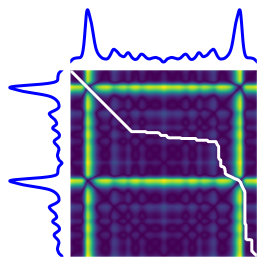

In [2]:
import numpy
from scipy.spatial.distance import cdist
from tslearn import metrics

s_x = numpy.loadtxt("../data/sample_series.txt")
s_y1 = numpy.concatenate((s_x, s_x)).reshape((-1, 1))
s_y2 = numpy.concatenate((s_x, s_x[::-1])).reshape((-1, 1))

path, sim = metrics.dtw_path(s_y1, s_y2)
mat = cdist(s_y1, s_y2)

plot_path(s_y1, s_y2, mat, path)

## Algorithmic Solution

There exists an $O(mn)$ algorithm to compute the exact optimum for this
problem (assuming computation of $d(\cdot,\cdot)$ is $O(1)$):

```python
def dtw(x, x_prime, q=2):
  for i in 1..n:
    for j in 1..m:
      dist = d(x[i], x_prime[j]) ** q
      if i == 1 and j == 1:
        gamma[i, j] = dist
      else:
        gamma[i, j] = dist + min(gamma[i-1, j] if i > 1
                                               else inf,
                                 gamma[i, j-1] if j > 1
                                               else inf,
                                 gamma[i-1, j-1] if (i > 1 and j > 1)
                                                 else inf)

  return (gamma[n, m]) ** (1. / q)
```

The basic idea behind this algorithm is that there exists a recurrence relationship between partial DTW computations.
More precisely, if we denote by $\gamma_{i,j}$ the $DTW_q$ (at power $q$) similarity between sequences $\mathbf{x}_{\rightarrow i}$ and $\mathbf{x}^\prime_{\rightarrow j}$ (where the notation $\mathbf{x}_{\rightarrow i}$ denotes sequence $\mathbf{x}$ observed up to time $i$), then we have:

\begin{eqnarray}

\gamma_{i,j} &=& DTW_q(\mathbf{x}_{\rightarrow i}, \mathbf{x}^\prime_{\rightarrow j})^q \\
&=&
    \min_{\pi \in \mathcal{A}(\mathbf{x}_{\rightarrow i}, \mathbf{x}^\prime_{\rightarrow j})}
        \sum_{(k, l) \in \pi} d(x_k, x^\prime_l)^q \\
&\stackrel{*}{=}& d(x_i, x^\prime_j)^q +
    \min_{\pi \in \mathcal{A}(\mathbf{x}_{\rightarrow i}, \mathbf{x}^\prime_{\rightarrow j})}
        \sum_{(k, l) \in \pi[:-1]} d(x_k, x^\prime_l)^q \\
&\stackrel{**}{=}& d(x_i, x^\prime_j)^q +
    \min (\gamma_{i-1, j}, \gamma_{i, j-1}, \gamma_{i-1, j-1})
\end{eqnarray}

and $DTW_q(\mathbf{x}, \mathbf{x}^\prime)$ is then $(\gamma_{n, m})^{\frac{1}{q}}$.
In more details:
* $(*)$ comes from the constraints on admissible paths $\pi$: the last element on an admissible path needs to match the last elements of the series;
* $(**)$ comes from the contiguity conditions on the admissible paths: all admissible paths that match $x_i$ with $x^\prime_j$ need to go through one of these 3 possible ancestors: $(i-1, j)$, $(i, j-1)$ or $(i-1, j-1)$.

The dynamic programming algorithm presented above relies on this recurrence formula and stores intermediate computations for efficiency.


## Properties

Dynamic Time Warping holds the following properties:

* $\forall \mathbf{x}, \mathbf{x}^\prime, DTW_q(\mathbf{x}, \mathbf{x}^\prime) \geq 0$
* $\forall \mathbf{x}, DTW_q(\mathbf{x}, \mathbf{x}) = 0$
* Suppose $\mathbf{x}$ is a time series that is constant except for a motif that
occurs at some point in the series, and let us denote by $\mathbf{x}_{+k}$ a
copy of $\mathbf{x}$ in which the motif is temporally shifted by $k$ timestamps,
then $DTW_q(\mathbf{x}, \mathbf{x}_{+k}) = 0$.

However, mathematically speaking, DTW is not a valid metric since it
satisfies neither the triangular inequality nor the identity of indiscernibles.

## Setting additional constraints

The set of temporal deformations to which DTW is invariant can be reduced by
imposing additional constraints on the set of acceptable paths.
Such constraints typically consist in forcing paths to stay close to the
diagonal.

The Sakoe-Chiba band is parametrized by a radius $r$ (number of
off-diagonal elements to consider, also called warping window size sometimes),
as illustrated below:

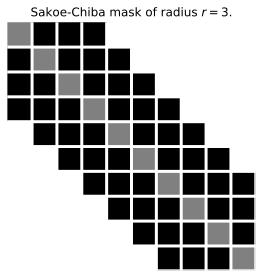

In [3]:
from tslearn.metrics import sakoe_chiba_mask

sz = 10

m = sakoe_chiba_mask(sz, sz, radius=3)
m[m == numpy.inf] = 1.
numpy.fill_diagonal(m, .5)

plt.figure()
plt.imshow(m, cmap="gray")
plot_constraints("Sakoe-Chiba mask of radius $r=3$.", sz)

````{admonition} tslearn tip
:class: tip, dropdown

A typical call to DTW with Sakoe-Chiba band constraint in
``tslearn`` would be:

```python
from tslearn.metrics import dtw
cost = dtw(
  x, x_prime,
  global_constraint="sakoe_chiba",
  sakoe_chiba_radius=3
)
```

````

The Itakura parallelogram sets a maximum slope $s$ for alignment
paths, which leads to a parallelogram-shaped constraint:

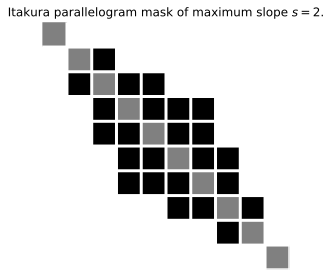

In [4]:
from tslearn.metrics import itakura_mask

sz = 10

m = itakura_mask(sz, sz, max_slope=2.)
m[m == numpy.inf] = 1.
numpy.fill_diagonal(m, .5)

plt.figure()
plt.imshow(m, cmap="gray")
plot_constraints("Itakura parallelogram mask of maximum slope $s=2$.", sz)

````{admonition} tslearn tip
:class: tip, dropdown

A typical call to DTW with Itakura parallelogram constraint in
``tslearn`` would be:

```python
from tslearn.metrics import dtw
cost = dtw(
  x, x_prime,
  global_constraint="itakura",
  itakura_max_slope=2.
)
```
````

## Computing barycenters

As illustrated in our introductory example, the ability to compute barycenters
for a given similarity measure is necessary for its use in some methods such as
$k$-means.

A barycenter of a set of samples $\{\mathbf{x}_1, \dots, \mathbf{x}_N\}$
is a solution, for a given metric $d(\cdot,\cdot)$,
of the following optimization problem:

```{math}
:label: eq:barycenter
    \min_\mathbf{b} \sum_i d(\mathbf{b}, \mathbf{x}_i)^2 .
```

When $d(\cdot,\cdot)$ is the Euclidean distance, the exact minimizer of this
quantity is known in closed form (each coordinate of the barycenter is the
average -- over points in the set -- of the corresponding coordinate).

However, here we are rather interested in computing barycenters with
respect to the Dynamic Time Warping similarity measure.
Optimizing this quantity can be done through the
**DTW Barycenter Averaging (DBA)** algorithm presented in
{cite}`PETITJEAN2011678`.
This algorithm repeats the following two steps until convergence:

1. Compute Dynamic Time Warping and associated matching $\pi$ between the
current barycenter and each of the time series in the set. Based on that,
update, for
each temporal position of the barycenter, a list of the points in time series
from the set that are matched to this timestamp through DTW ;
2. Update each element in the barycenter as the average of all its associated
points (as stored at the previous step).

This algorithm is illustrated in the animation below (do not hesitate to slow
it down using the "-" button) in which black segments figure assignments of
time series elements to barycenter elements (here a barycenter of 2 time series
is performed and the barycenter is represented in purple).

In [5]:
from IPython.display import HTML
from celluloid import Camera

import warnings
from sklearn.exceptions import ConvergenceWarning

from tslearn.barycenters import _set_weights, euclidean_barycenter
from tslearn.metrics import dtw_path
from tslearn.utils import ts_size, to_time_series_dataset

def _mm_assignment(X, barycenter, weights, metric_params=None):
    """Computes item assignement based on DTW alignments and return cost as a
    bonus.

    Parameters
    ----------
    X : numpy.array of shape (n, sz, d)
        Time-series to be averaged

    barycenter : numpy.array of shape (barycenter_size, d)
        Barycenter as computed at the current step of the algorithm.

    weights: array
        Weights of each X[i]. Must be the same size as len(X).

    metric_params: dict or None (default: None)
        DTW constraint parameters to be used.
        See :ref:`tslearn.metrics.dtw_path <fun-tslearn.metrics.dtw_path>` for
        a list of accepted parameters
        If None, no constraint is used for DTW computations.

    Returns
    -------
    list of index pairs
        Warping paths

    float
        Current alignment cost
    """
    if metric_params is None:
        metric_params = {}
    n = X.shape[0]
    cost = 0.
    list_p_k = []
    for i in range(n):
        path, dist_i = dtw_path(barycenter, X[i], **metric_params)
        cost += dist_i ** 2 * weights[i]
        list_p_k.append(path)
    cost /= weights.sum()
    return list_p_k, cost


def _subgradient_valence_warping(list_p_k, barycenter_size, weights):
    """Compute Valence and Warping matrices from paths.

    Valence matrices are denoted :math:`V^{(k)}` and Warping matrices are
    :math:`W^{(k)}` in [1]_.

    This function returns a list of :math:`V^{(k)}` diagonals (as a vector)
    and a list of :math:`W^{(k)}` matrices.

    Parameters
    ----------
    list_p_k : list of index pairs
        Warping paths

    barycenter_size : int
        Size of the barycenter to generate.

    weights: array
        Weights of each X[i]. Must be the same size as len(X).

    Returns
    -------
    list of numpy.array of shape (barycenter_size, )
        list of weighted :math:`V^{(k)}` diagonals (as a vector)

    list of numpy.array of shape (barycenter_size, sz_k)
        list of weighted :math:`W^{(k)}` matrices

    References
    ----------

    .. [1] D. Schultz and B. Jain. Nonsmooth Analysis and Subgradient Methods
       for Averaging in Dynamic Time Warping Spaces.
       Pattern Recognition, 74, 340-358.
    """
    list_v_k = []
    list_w_k = []
    for k, p_k in enumerate(list_p_k):
        sz_k = p_k[-1][1] + 1
        w_k = numpy.zeros((barycenter_size, sz_k))
        for i, j in p_k:
            w_k[i, j] = 1.
        list_w_k.append(w_k * weights[k])
        list_v_k.append(w_k.sum(axis=1) * weights[k])
    return list_v_k, list_w_k


def _mm_valence_warping(list_p_k, barycenter_size, weights):
    """Compute Valence and Warping matrices from paths.

    Valence matrices are denoted :math:`V^{(k)}` and Warping matrices are
    :math:`W^{(k)}` in [1]_.

    This function returns the sum of :math:`V^{(k)}` diagonals (as a vector)
    and a list of :math:`W^{(k)}` matrices.

    Parameters
    ----------
    list_p_k : list of index pairs
        Warping paths

    barycenter_size : int
        Size of the barycenter to generate.

    weights: array
        Weights of each X[i]. Must be the same size as len(X).

    Returns
    -------
    numpy.array of shape (barycenter_size, )
        sum of weighted :math:`V^{(k)}` diagonals (as a vector)

    list of numpy.array of shape (barycenter_size, sz_k)
        list of weighted :math:`W^{(k)}` matrices

    References
    ----------

    .. [1] D. Schultz and B. Jain. Nonsmooth Analysis and Subgradient Methods
       for Averaging in Dynamic Time Warping Spaces.
       Pattern Recognition, 74, 340-358.
    """
    list_v_k, list_w_k = _subgradient_valence_warping(
        list_p_k=list_p_k,
        barycenter_size=barycenter_size,
        weights=weights)
    diag_sum_v_k = numpy.zeros(list_v_k[0].shape)
    for v_k in list_v_k:
        diag_sum_v_k += v_k
    return diag_sum_v_k, list_w_k


def _mm_update_barycenter(X, diag_sum_v_k, list_w_k):
    """Update barycenters using the formula from Algorithm 2 in [1]_.

    Parameters
    ----------
    X : numpy.array of shape (n, sz, d)
        Time-series to be averaged

    diag_sum_v_k : numpy.array of shape (barycenter_size, )
        sum of weighted :math:`V^{(k)}` diagonals (as a vector)

    list_w_k : list of numpy.array of shape (barycenter_size, sz_k)
        list of weighted :math:`W^{(k)}` matrices

    Returns
    -------
    numpy.array of shape (barycenter_size, d)
        Updated barycenter

    References
    ----------

    .. [1] D. Schultz and B. Jain. Nonsmooth Analysis and Subgradient Methods
       for Averaging in Dynamic Time Warping Spaces.
       Pattern Recognition, 74, 340-358.
    """
    d = X.shape[2]
    barycenter_size = diag_sum_v_k.shape[0]
    sum_w_x = numpy.zeros((barycenter_size, d))
    for k, (w_k, x_k) in enumerate(zip(list_w_k, X)):
        sum_w_x += w_k.dot(x_k[:ts_size(x_k)])
    barycenter = numpy.diag(1. / diag_sum_v_k).dot(sum_w_x)
    return barycenter


def dtw_barycenter_averaging(X, barycenter_size=None,
                             init_barycenter=None,
                             max_iter=30, tol=1e-5, weights=None,
                             metric_params=None,
                             verbose=False):
    """DTW Barycenter Averaging (DBA) method estimated through
    Expectation-Maximization algorithm.

    DBA was originally presented in [1]_.
    This implementation is based on a idea from [2]_ (Majorize-Minimize Mean
    Algorithm).

    Parameters
    ----------
    X : array-like, shape=(n_ts, sz, d)
        Time series dataset.

    barycenter_size : int or None (default: None)
        Size of the barycenter to generate. If None, the size of the barycenter
        is that of the data provided at fit
        time or that of the initial barycenter if specified.

    init_barycenter : array or None (default: None)
        Initial barycenter to start from for the optimization process.

    max_iter : int (default: 30)
        Number of iterations of the Expectation-Maximization optimization
        procedure.

    tol : float (default: 1e-5)
        Tolerance to use for early stopping: if the decrease in cost is lower
        than this value, the
        Expectation-Maximization procedure stops.

    weights: None or array
        Weights of each X[i]. Must be the same size as len(X).
        If None, uniform weights are used.

    metric_params: dict or None (default: None)
        DTW constraint parameters to be used.
        See :ref:`tslearn.metrics.dtw_path <fun-tslearn.metrics.dtw_path>` for
        a list of accepted parameters
        If None, no constraint is used for DTW computations.

    verbose : boolean (default: False)
        Whether to print information about the cost at each iteration or not.

    Returns
    -------
    numpy.array of shape (barycenter_size, d) or (sz, d) if barycenter_size \
            is None
        DBA barycenter of the provided time series dataset.
    float
        Associated inertia
    list of numpy.array of shape (barycenter_size, d) or (sz, d) if \
        barycenter_size is None
        list of DBA barycenters along iterations.
    list of list of alignment paths
        list of alignment paths along iterations.

    References
    ----------
    .. [1] F. Petitjean, A. Ketterlin & P. Gancarski. A global averaging method
       for dynamic time warping, with applications to clustering. Pattern
       Recognition, Elsevier, 2011, Vol. 44, Num. 3, pp. 678-693

    .. [2] D. Schultz and B. Jain. Nonsmooth Analysis and Subgradient Methods
       for Averaging in Dynamic Time Warping Spaces.
       Pattern Recognition, 74, 340-358.
    """
    X_ = to_time_series_dataset(X)
    if barycenter_size is None:
        barycenter_size = X_.shape[1]
    weights = _set_weights(weights, X_.shape[0])
    if init_barycenter is None:
        barycenter = euclidean_barycenter(X_)
    else:
        barycenter_size = init_barycenter.shape[0]
        barycenter = init_barycenter
    cost_prev, cost = numpy.inf, numpy.inf
    list_barycenters = [barycenter]
    list_assignments = []
    for it in range(max_iter):
        list_p_k, cost = _mm_assignment(X_, barycenter, weights, metric_params)
        list_assignments.append(list_p_k)
        diag_sum_v_k, list_w_k = _mm_valence_warping(list_p_k, barycenter_size,
                                                     weights)
        if verbose:
            print("[DBA] epoch %d, cost: %.3f" % (it + 1, cost))
        barycenter = _mm_update_barycenter(X_, diag_sum_v_k, list_w_k)
        list_barycenters.append(barycenter)
        if abs(cost_prev - cost) < tol:
            break
        elif cost_prev < cost:
            warnings.warn("DBA loss is increasing while it should not be. "
                          "Stopping optimization.", ConvergenceWarning)
            break
        else:
            cost_prev = cost
    return barycenter, cost, list_barycenters, list_assignments

def plot_and_snap(X, bar, assign, step, camera):
    if assign is not None:
        for idx in range(n_ts):
            for ti, tj in assign[idx]:
                plt.plot([ti, tj], [bar[ti, 0], X[idx, tj, 0]], 'k-',
                         alpha=.5)
    plt.plot(numpy.arange(sz), X[0].ravel(), "r-", marker="o")
    plt.plot(numpy.arange(sz), X[1].ravel(), "b-", marker="o")
    plt.plot(numpy.arange(sz), bar.ravel(), "-", marker="o", color="purple")
    plt.ylim([X.min() - .1, X.max() + .1])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    camera.snap()

# Main code
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMinMax, TimeSeriesResampler

X_train, y_train, X_test, y_test = CachedDatasets().load_dataset("Trace")
sz, d = X_train.shape[1:]
n_ts = 2
X_out = numpy.empty((n_ts, sz, d))

X_out[0] = X_train[y_train == 1][0]
X_out[1] = X_train[y_train == 2][0]
X_out = TimeSeriesScalerMinMax().fit_transform(X_out)
sz = 30
X_out = TimeSeriesResampler(sz=sz).fit_transform(X_out)

_, _, list_barycenters, list_assignments = dtw_barycenter_averaging(X_out)

# For visualization purposes
X_out[0] += 1.
X_out[1] -= 1.

assignments_i = None
bar_i = None
step = 0
fig = plt.figure()
camera = Camera(fig)
for i in range(len(list_assignments)):
    # Update barycenter
    bar_i = list_barycenters[i]
    plot_and_snap(X_out, bar_i, assignments_i, step, camera)
    step += 1

    # Update assignments
    assignments_i = list_assignments[i]
    plot_and_snap(X_out, bar_i, assignments_i, step, camera)
    step += 1
anim = camera.animate()
plt.close()

HTML(anim.to_jshtml())

```{admonition} Some other alignment-based metrics

Though DTW is probably the most well-known alignment-based similarity measure
for time series, it is not the only one.
Some other similarity measures rely on local matches rather than matching
the whole series.
This is the case of
[Longest Common Sub-Sequence (LCSS)](https://en.wikipedia.org/wiki/Longest_common_subsequence_problem) and
[Longest Common Substring (LCS)](https://en.wikipedia.org/wiki/Longest_common_substring_problem)
algorithms.

Also, the problem of aligning heterogeneous time series (_i.e._ time series
whose elements either do not lie in the same ambient space or cannot be
compared directly) has received some attention.
A first similarity measure in this context is Canonical Time Warping
{cite}`zhou2009canonical` which finds both a common embedding space for features
of both time series (using Canonical Correlation Analysis) and an optimal
alignment path _à la_ DTW.
More recent works on this problem aim at either mapping one series' features
to the other series' feature space {cite}`vayer2020time` or matching
self-similarity matrices {cite}`cohen2020aligning`.
```

## References

```{bibliography} ../../references.bib
:filter: docname in docnames
```